## **Time Series Analysis of Bitcoin Prices (USD)**


In [70]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [51]:
df=yf.download("BTC-USD")

[*********************100%***********************]  1 of 1 completed


In [52]:
df

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...
2025-05-22,111673.281250,111970.171875,109285.070312,109673.492188,70157575642
2025-05-23,107287.796875,111798.906250,106841.304688,111679.359375,67548133399


In [53]:
print(f"Taille totale de l'échantillon : {len(df)} jours")

Taille totale de l'échantillon : 3905 jours


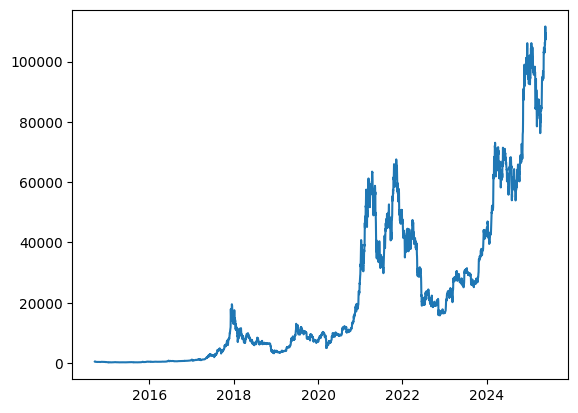

In [54]:
plt.plot(df.index ,df["Close"])
plt.show()

## Préparation des données

In [55]:
n_total_obser = len(df)
n_train_obser = int(n_total_obser * 0.8)
n_test_obser = n_total_obser - n_train_obser

training_data = pd.Series(df["Close"].iloc[:n_train_obser].values.flatten(), dtype="float64")
testing_data = pd.Series(df["Close"].iloc[n_train_obser:].values.flatten(), dtype="float64")

## Division des données en jeu d'entraînement et jeu de test


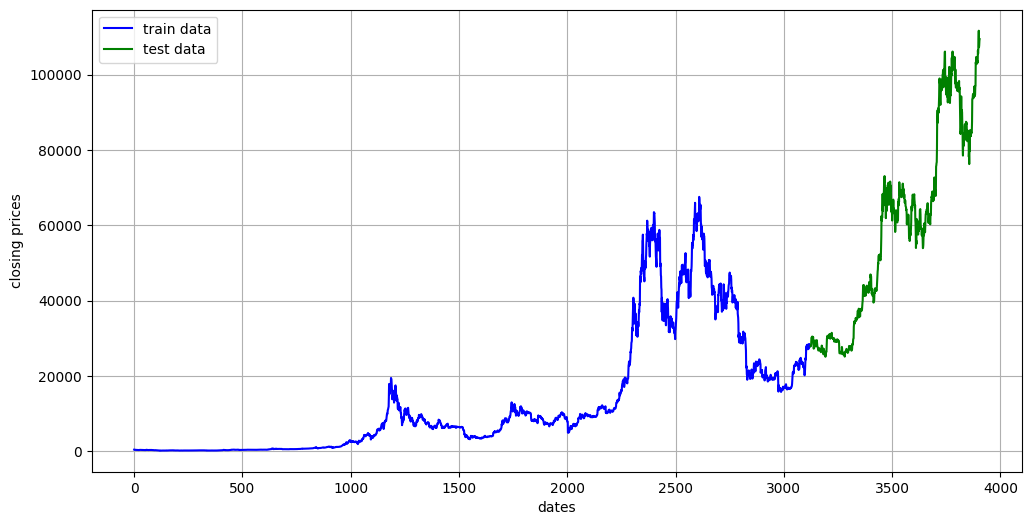

In [56]:
train_index = range(n_train_obser)
test_index = range(n_train_obser, n_total_obser)
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.xlabel("dates")
plt.ylabel("closing prices")
plt.plot(train_index, training_data, color="blue", label="train data")
plt.plot(test_index, testing_data, color="green", label="test data")
plt.legend()
plt.show()

## **Vérification de la stationnarité et décomposition STL de la série**

## Étape 1 : Décomposition additive 

Décomposition additive :


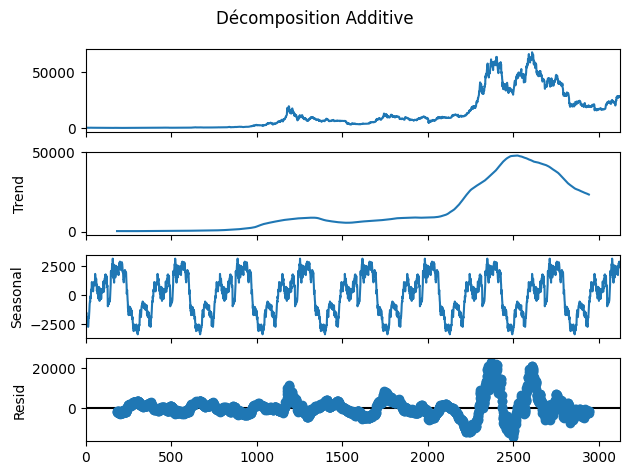

In [57]:
decomposition_add = seasonal_decompose(training_data, model='additive', period=365)
print("Décomposition additive :")
decomposition_add.plot()
plt.suptitle("Décomposition Additive")
plt.tight_layout()
plt.show()

## Étape 2 : Décomposition multiplicative 

Décomposition multiplicative :


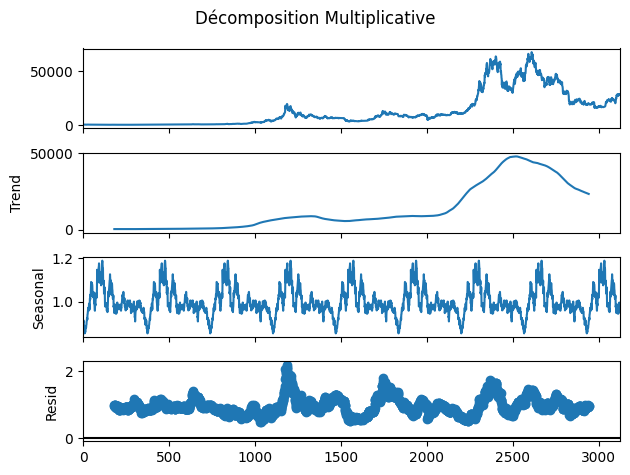

In [58]:
 decomposition_mul = seasonal_decompose(training_data, model='multiplicative', period=365)
print("Décomposition multiplicative :")
decomposition_mul.plot()
plt.suptitle("Décomposition Multiplicative")
plt.tight_layout()
plt.show()

## Étape 3 : Appliquer une transformation logarithmique 

In [59]:
# On prend le logarithme naturel (np.log) pour transformer le modèle multiplicatif en additif
train_log = np.log(training_data)

Décomposition additive sur la série logarithmique :


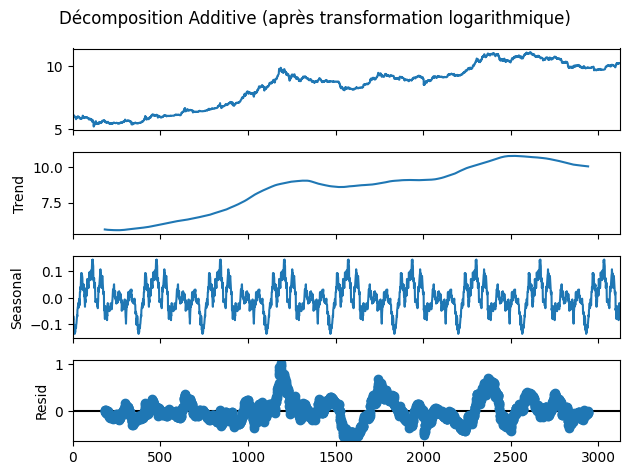

In [60]:
decomposition_log = seasonal_decompose(train_log, model='additive', period=365)
print("Décomposition additive sur la série logarithmique :")
decomposition_log.plot()
plt.suptitle("Décomposition Additive (après transformation logarithmique)")
plt.tight_layout()
plt.show()

## Dickey–Fuller test 

In [61]:
result=adfuller(train_log.values)
print ('ADF Statistic : %f ' %result[0])
print ('p_value : %f ' %result[1])

ADF Statistic : -0.877010 
p_value : 0.795449 


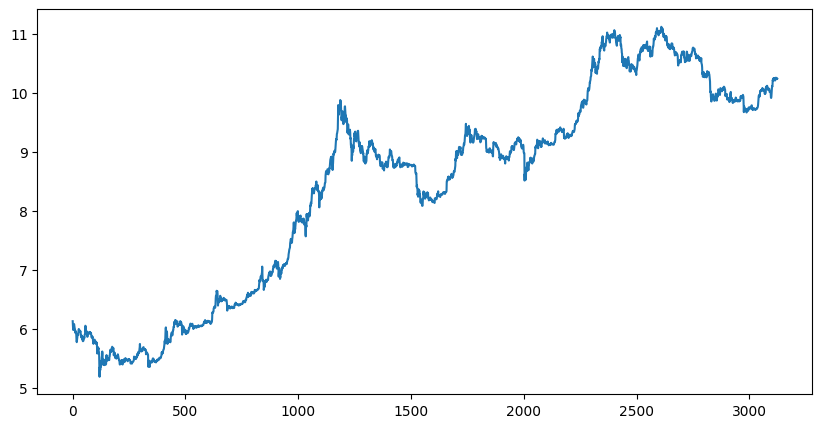

In [62]:
#sans differenciation 
plt.figure(figsize=(10,5))
plt.plot(train_log)

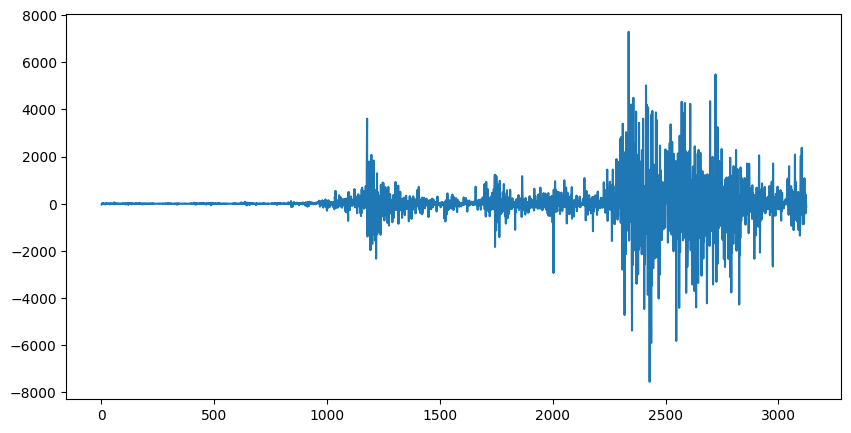

In [63]:
#avec differenciation
plt.figure(figsize=(10,5))
plt.plot(training_data.diff())

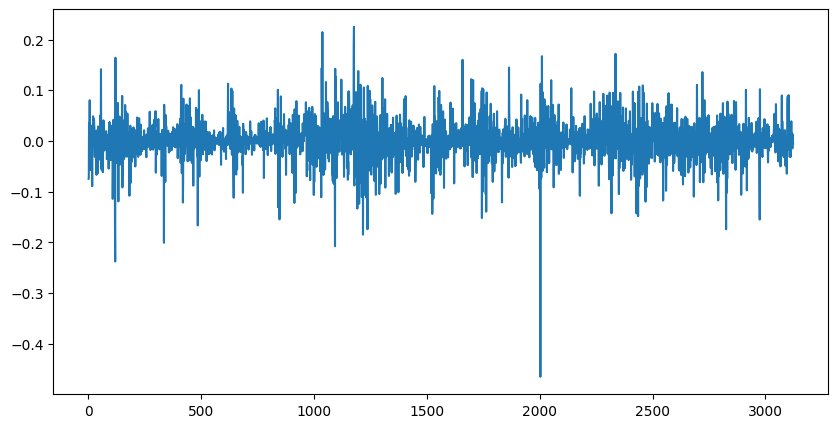

In [64]:
#avec differenciation log
plt.figure(figsize=(10,5))
plt.plot(train_log.diff())

## Étude des fonctions d'autocorrélation (ACF) et d'autocorrélation partielle (PACF)

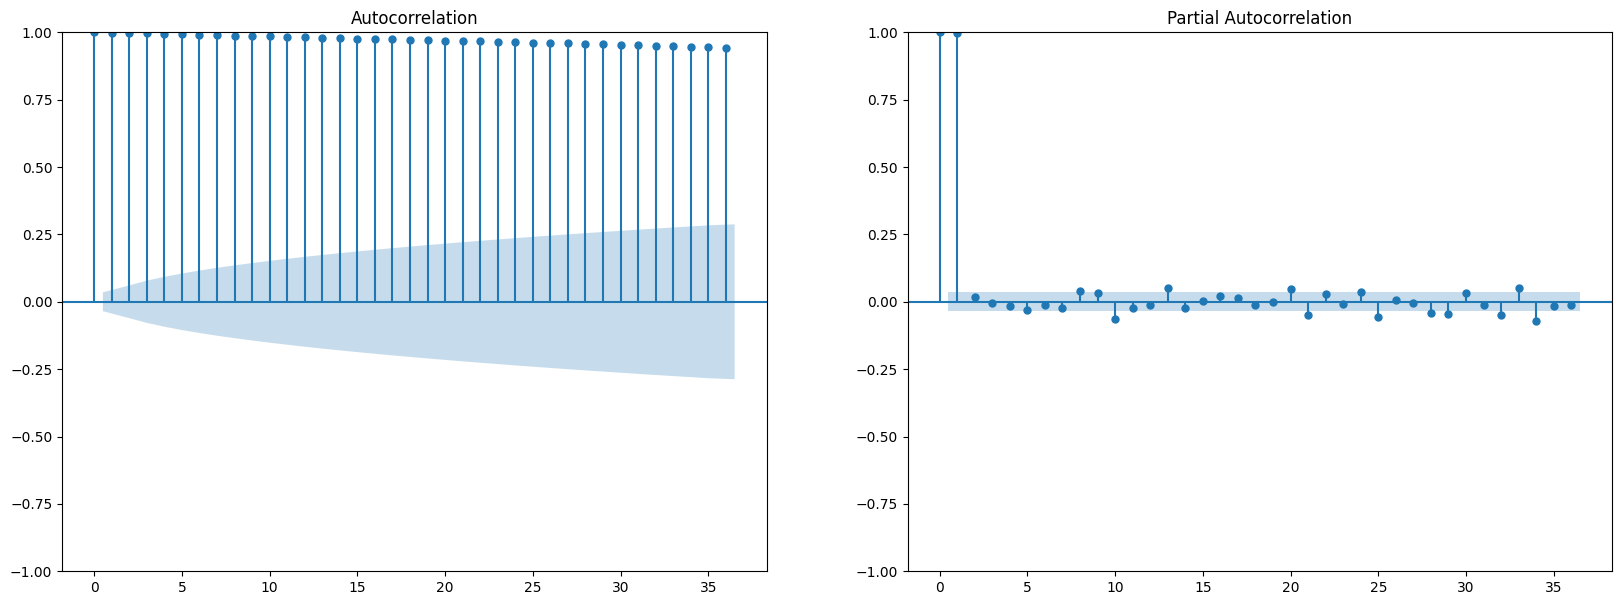

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plot_acf(training_data.dropna(), lags=36, ax=ax1)
plot_pacf(training_data.dropna(), lags=36, ax=ax2)

plt.show()

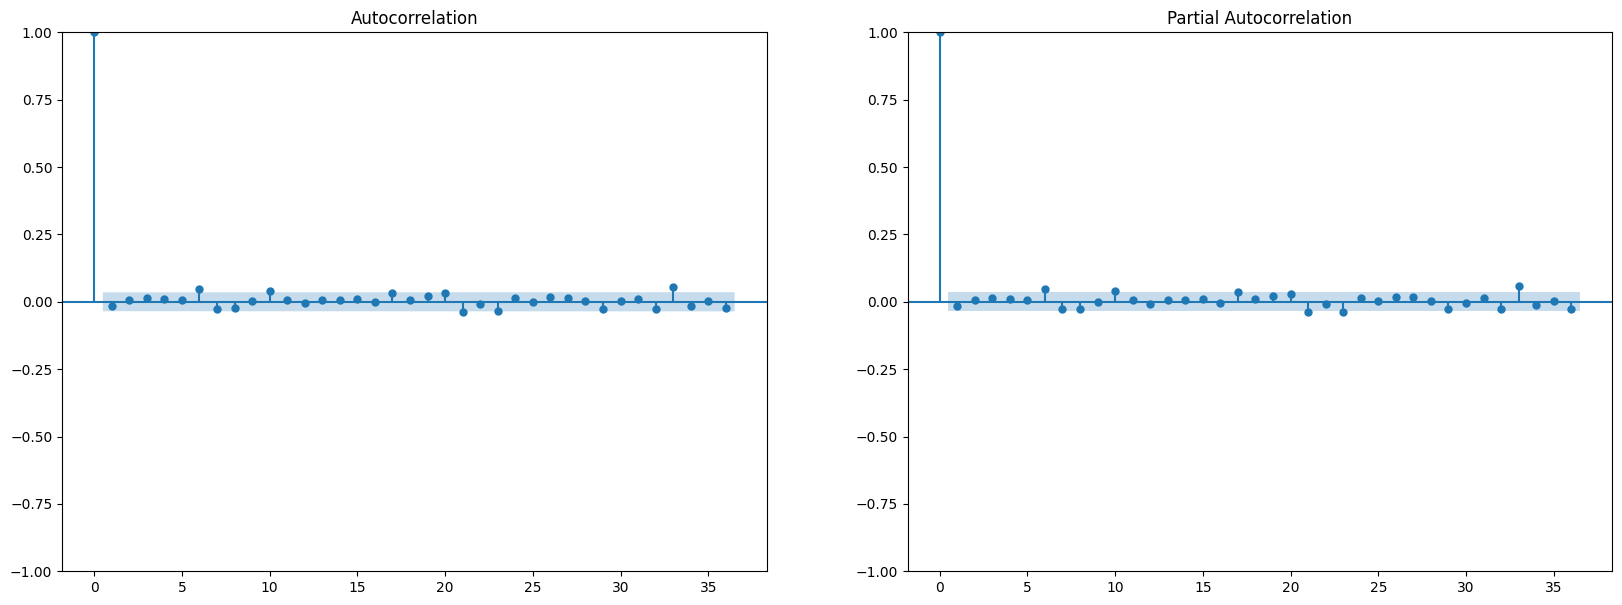

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plot_acf(train_log.diff().dropna(), lags=36, ax=ax1)
plot_pacf(train_log.diff().dropna(), lags=36, ax=ax2)

plt.show()

## Choix et validation du modèle ARIMA

In [67]:
# Modèle ARIMA(1,1,0)
model_110 = ARIMA(train_log.diff(), order=(1, 1, 0))
result_110 = model_110.fit()
# Modèle ARIMA(0,1,1)
model_011 = ARIMA(train_log.diff(), order=(0, 1, 1))
result_011 = model_011.fit()
# Modèle ARIMA(1,1,1)
model_111 = ARIMA(train_log.diff(), order=(1, 1, 1))
result_111 = model_111.fit()
# Résumé des résultats
print("ARIMA(1,1,1) AIC:", result_111.aic)
print("ARIMA(1,1,1) BIC:", result_111.bic)
print("ARIMA(1,1,0) AIC:", result_110.aic)
print("ARIMA(1,1,0) BIC:", result_110.bic)
print("ARIMA(0,1,1) AIC:", result_011.aic)
print("ARIMA(0,1,1) BIC:", result_011.bic)

ARIMA(1,1,1) AIC: -11468.240979814396
ARIMA(1,1,1) BIC: -11450.101331742548
ARIMA(1,1,0) AIC: -10212.554426377033
ARIMA(1,1,0) BIC: -10200.461327662468
ARIMA(0,1,1) AIC: -11469.032368049036
ARIMA(0,1,1) BIC: -11456.93926933447


In [68]:
model = ARIMA(train_log, order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3124
Model:                 ARIMA(0, 1, 1)   Log Likelihood                5749.213
Date:                Wed, 28 May 2025   AIC                         -11494.426
Time:                        02:06:45   BIC                         -11482.333
Sample:                             0   HQIC                        -11490.085
                               - 3124                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0164      0.011     -1.458      0.145      -0.038       0.006
sigma2         0.0015   1.48e-05     99.355      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   0.00   Jarque-

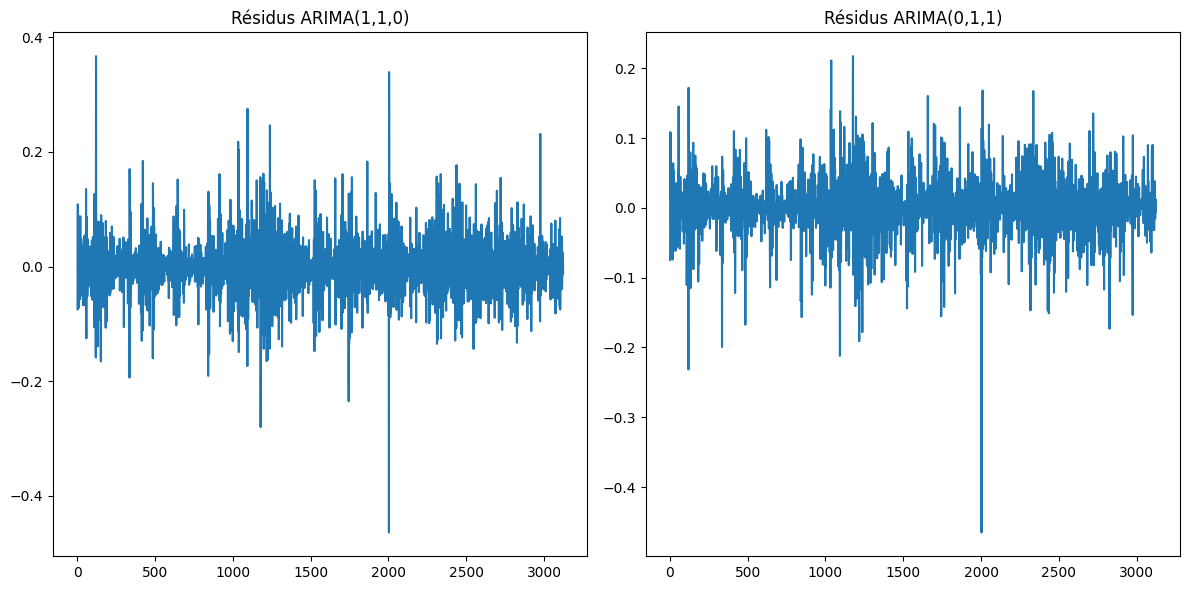

In [69]:
# Tracer les résidus pour vérifier le bruit blanc
residuals_110 = result_110.resid
residuals_011 = result_011.resid

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(residuals_110)
plt.title("Résidus ARIMA(1,1,0)")

plt.subplot(1,2,2)
plt.plot(residuals_011)
plt.title("Résidus ARIMA(0,1,1)")
plt.tight_layout()
plt.show()

In [72]:
# Ajuster un modèle ARIMA (par exemple : ARIMA(0,1,1))
model = ARIMA(training_data, order=(0, 1, 1))
model_fit = model.fit()

# Extraire les résidus du modèle
residuals = model_fit.resid

# Test de Ljung-Box
ljungbox_result = acorr_ljungbox(residuals, lags=[10], return_df=True)

print("Résultat du test de Ljung-Box :")
print(ljungbox_result)


Résultat du test de Ljung-Box :
      lb_stat  lb_pvalue
10  40.837159   0.000012


**conclusion : Bien que le test de Ljung-Box indique que les résidus ne sont pas entièrement un bruit blanc (p-value < 5%), l’analyse visuelle montre que ces derniers sont globalement centrés autour de zéro, avec une variance faible et stable. À l’exception d’un pic isolé à -0.4, la majorité des résidus fluctue entre -0.2 et 0.2. De plus, les critères d’information (AIC, BIC) et les performances prédictives confirment que le modèle ARIMA(0,1,1) est bien adapté à notre série. Ce modèle est donc retenu pour l’étude malgré cette légère imperfection statistique.**



## Prévision

In [23]:
model_prediction=[]
n_test_obser =len(testing_data)

In [73]:
training_data = pd.Series(df["Close"].iloc[:n_train_obser].values.flatten(), dtype="float64")
testing_data = pd.Series(df["Close"].iloc[n_train_obser:].values.flatten(), dtype="float64")

model_prediction = []

for i in range(n_test_obser):
    model = ARIMA(training_data, order=(0, 1, 1))
    model_fit = model.fit()

    yhat = model_fit.forecast().iloc[0] 
    model_prediction.append(yhat)

    #  concat à la place de append
    actual_test_value = testing_data.iloc[i]
    training_data = pd.concat([training_data, pd.Series([actual_test_value])], ignore_index=True)


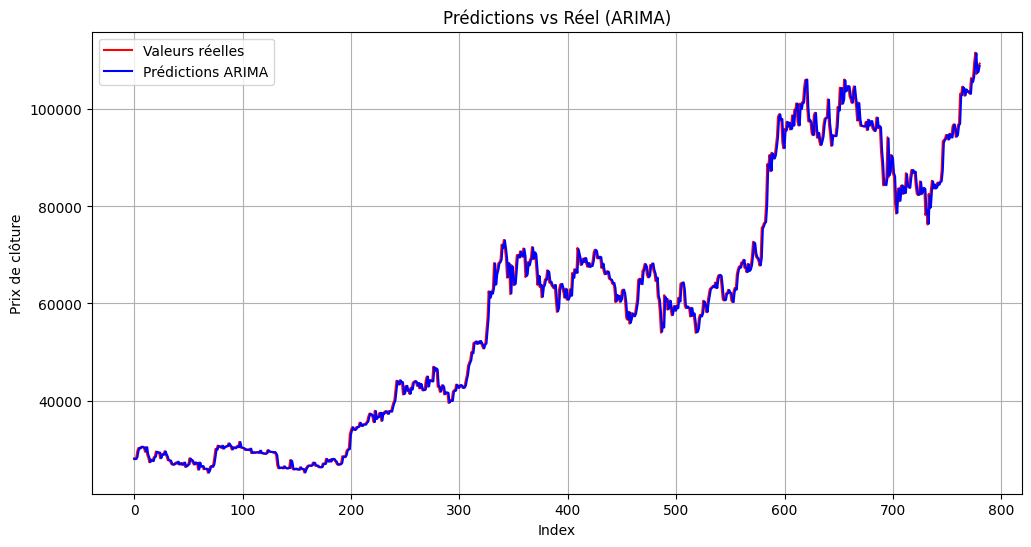

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(testing_data.values, label="Valeurs réelles", color='Red')
plt.plot(model_prediction, label="Prédictions ARIMA", color='blue')
plt.title("Prédictions vs Réel (ARIMA)")
plt.xlabel("Index")
plt.ylabel("Prix de clôture")
plt.legend()
plt.grid()
plt.show()


In [75]:
# Convertir les prédictions et les valeurs réelles en tableaux numpy
preds = np.array(model_prediction)
actuals = testing_data.values

# S’assurer que les deux ont la même taille (au cas où)
min_len = min(len(preds), len(actuals))
preds = preds[:min_len]
actuals = actuals[:min_len]

# Eviter division par zéro (remplacer 0 par un très petit nombre)
actuals_safe = np.where(actuals == 0, 1e-10, actuals)

# Calcul MAPE
mape = np.mean(np.abs((preds - actuals) / actuals_safe)) * 100

print('MAPE : ' + str(mape) + '%')


MAPE : 1.758606543003495%


## Utilisation d’Auto ARIMA pour l’identification optimale du modèle

In [82]:
df.index = pd.to_datetime(df.index)
# On regroupe par mois pour obtenir une série mensuelle moyenne
df_month = df['Close'].resample('M').mean()
print(df_month.head())
# Lancement de l’auto_arima pour déterminer les meilleurs paramètres ARIMA avec une saisonnalité annuelle (m=12)
model = auto_arima(
    df_month,
    seasonal=True,
    m=12,  # saison annuelle
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

# Résumé du modèle sélectionné
print(model.summary())

C:\Users\smart\AppData\Local\Temp\ipykernel_9380\3676766716.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_month = df['Close'].resample('M').mean()
c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings

Ticker         BTC-USD
Date                  
2014-09-30  407.182428
2014-10-31  364.148873
2014-11-30  366.099799
2014-12-31  341.267871
2015-01-31  248.782547
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2504.729, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2534.976, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2512.034, Time=0.08 sec


c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2502.183, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2536.571, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2500.475, Time=0.06 sec


c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2502.182, Time=0.12 sec


c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2504.182, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2501.829, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=2502.155, Time=0.09 sec


c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2510.085, Time=0.07 sec


c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=2503.847, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=2500.398, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=2501.997, Time=0.08 sec


c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12]             : AIC=2501.926, Time=0.11 sec


c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12]             : AIC=2503.683, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=2501.584, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=2501.668, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=2509.745, Time=0.03 sec


c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\smart\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[12]             : AIC=2501.709, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12]          
Total fit time: 2.811 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  129
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1248.199
Date:                Wed, 28 May 2025   AIC                           2500.398
Time:                        02:19:43   BIC                           2506.102
Sample:                    09-30-2014   HQIC                          2502.715
                         - 05-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5685      0.053     10.822      0.000       0.46

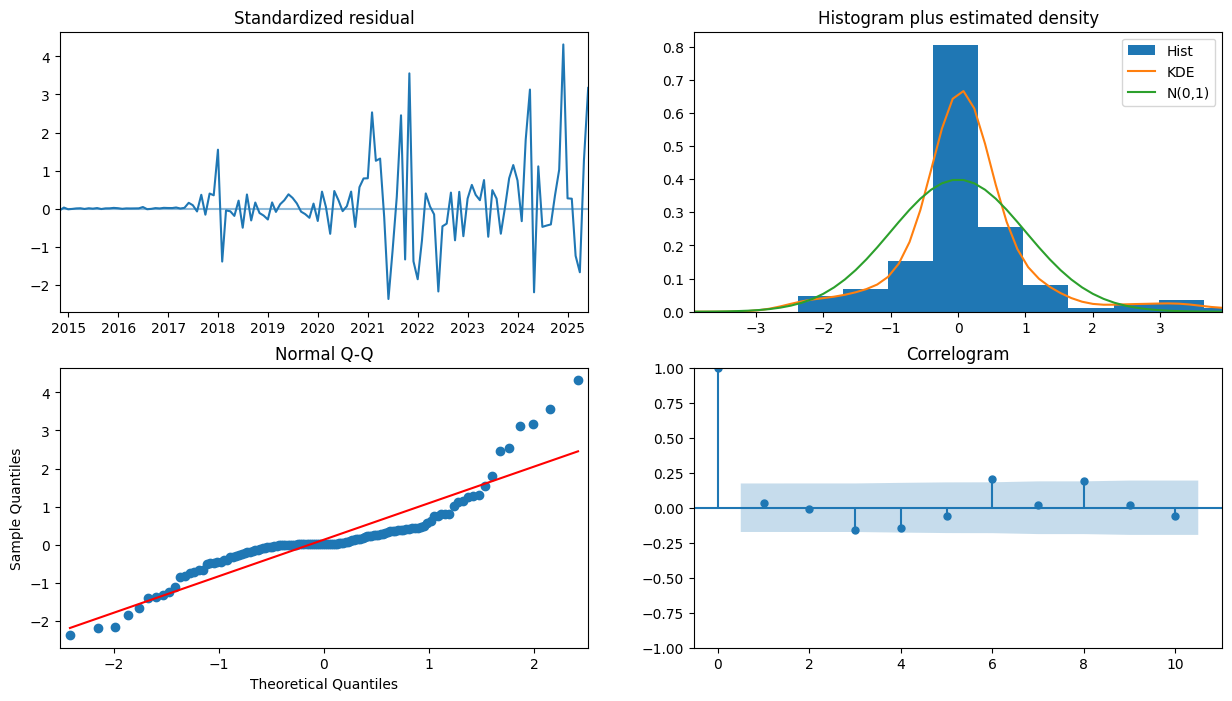

In [83]:
# Affichage des diagnostics
model.plot_diagnostics(figsize=(15, 8))
plt.show()